In [12]:

#dog breed indentifier using CNN
# Importing the libraries
import tensorflow as tf


# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# print(gpu_devices)

# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# This disables the GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except e:
    # Invalid device or cannot modify virtual devices once initialized.
    print(e)
    pass

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os
import cv2
import random
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
# from tensorflow.keras.callbacks import TensorBoard
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy

In [13]:
RESULTS_DIR = './results/'
IMG_SIZE = 299

BATCH_SIZE_PRE = 32
BATCH_SIZE_FINE = 16
EPOCHS_PRE = 10
EPOCHS_FINE = 20
MOMENTUM = 0.9

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    rotation_range = 10,
    horizontal_flip = True,
    validation_split = 0.2)

train_pre_generator = train_datagen.flow_from_directory(
    directory = "./data/fusion/train/",
    target_size = (IMG_SIZE, IMG_SIZE),
    color_mode = "rgb",
    batch_size = BATCH_SIZE_PRE,
    class_mode = "categorical")

train_fine_generator = train_datagen.flow_from_directory(
    directory = "./data/fusion/train/",
    target_size = (IMG_SIZE, IMG_SIZE),
    color_mode = "rgb",
    batch_size = BATCH_SIZE_FINE,
    class_mode = "categorical")

test_datagen = ImageDataGenerator(
    rescale=1.0/255
)
test_generator = test_datagen.flow_from_directory(
    directory = "./data/fusion/test/",
    batch_size = BATCH_SIZE_FINE,
    class_mode = "categorical"
)


Found 18680 images belonging to 172 classes.
Found 18680 images belonging to 172 classes.
Found 9355 images belonging to 172 classes.


In [15]:
assert len(os.listdir('./data/fusion/train/')) == len(os.listdir('./data/fusion/test/'))
num_breeds = len(os.listdir('./data/fusion/train/')) - 1
print("num_breeds:", num_breeds)

num_breeds: 172


In [16]:
xception_base_model = xception.Xception(include_top=False,
                                        weights='imagenet',
                                        input_shape=(299,299,3))

x_base_xception = xception_base_model.output
x_avg_pooling_xception = GlobalAveragePooling2D()(x_base_xception)
x_first_fc_xception = Dense(1024, activation='relu')(x_avg_pooling_xception)
x_last_fc_xception = Dense(num_breeds, activation='softmax')(x_first_fc_xception)

xception_custom_model = Model(inputs=xception_base_model.inputs, outputs=x_last_fc_xception)

xception_custom_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

In [11]:
#Train model - freeze body layers first
for layer in xception_base_model.layers:
    layer.trainable = False

xception_custom_model.compile(optimizer=SGD(momentum=MOMENTUM), loss=categorical_crossentropy, metrics=['accuracy'])

model_train_pre = xception_custom_model.fit_generator(
    generator = train_pre_generator,
    steps_per_epoch = (train_pre_generator.n//train_pre_generator.batch_size),
    epochs = EPOCHS_PRE,
    validation_data = test_generator,
    validation_steps = (test_generator.n//test_generator.batch_size),
    verbose=1
)

xception_custom_model.save(os.path.join(RESULTS_DIR, 'model_pre_2.h5'))

/tmp/ipykernel_113337/1785464405.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_train_pre = xception_custom_model.fit_generator(


Epoch 1/10
583/583 [==============================] - 1170s 2s/step - loss: 1.6356 - accuracy: 0.6854 - val_loss: 0.7242 - val_accuracy: 0.7940
Epoch 2/10
583/583 [==============================] - 1138s 2s/step - loss: 0.5562 - accuracy: 0.8327 - val_loss: 0.6964 - val_accuracy: 0.8064
Epoch 3/10
583/583 [==============================] - 1142s 2s/step - loss: 0.4682 - accuracy: 0.8511 - val_loss: 0.7026 - val_accuracy: 0.8105
Epoch 4/10
583/583 [==============================] - 1136s 2s/step - loss: 0.4182 - accuracy: 0.8671 - val_loss: 0.6832 - val_accuracy: 0.8176
Epoch 5/10
583/583 [==============================] - 1133s 2s/step - loss: 0.3843 - accuracy: 0.8736 - val_loss: 0.7260 - val_accuracy: 0.8098
Epoch 6/10
583/583 [==============================] - 1141s 2s/step - loss: 0.3568 - accuracy: 0.8828 - val_loss: 0.7153 - val_accuracy: 0.8161
Epoch 7/10
583/583 [==============================] - 1136s 2s/step - loss: 0.3288 - accuracy: 0.8901 - val_loss: 0.7299 - val_accuracy:

In [ ]:
#Train model - train all layers
for layer in xception_base_model.layers:
    layer.trainable = True
    
xception_custom_model.compile(optimizer=SGD(momentum=0.9), loss=categorical_crossentropy, metrics=['accuracy'] )

model_train_fine = xception_custom_model.fit_generator(
    generator = train_fine_generator,
    steps_per_epoch = (train_fine_generator.n//train_fine_generator.batch_size),
    epochs = EPOCHS_FINE,
    validation_data = test_generator,
    validation_steps = (test_generator.n//test_generator.batch_size),
    verbose = 1
)

xception_custom_model.save(os.path.join(RESULTS_DIR, 'model_fine.h5'))

/tmp/ipykernel_110808/3989455278.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_train_fine = xception_custom_model.fit_generator(


Epoch 1/10
   2/1167 [..............................] - ETA: 1:13:05 - loss: 5.1508 - accuracy: 0.0000e+00

<built-in method keys of dict object at 0x7fa95ba66080>


<function matplotlib.pyplot.show(close=None, block=None)>

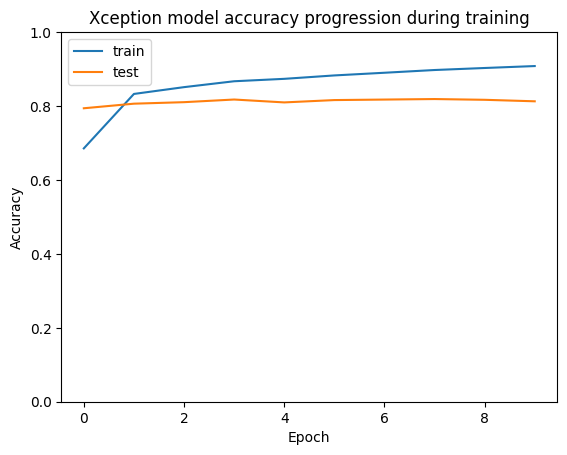

In [17]:
# Display progress of model training
print(model_train_pre.history.keys)
plt.plot(model_train_pre.history['accuracy'])
plt.plot(model_train_pre.history['val_accuracy'])
plt.title('Xception model accuracy progression during training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(0.0, 1.0)
plt.show